# Viola Jones NoteBook

In [49]:
import numpy as np
from typing import Final, Optional, Tuple, List
import matplotlib.pyplot as plt

from utils.decision_stamp import DecisionStamp
from utils.visualization import decision_stamp_visualization

Loading Example data

In [50]:
tmp_data_path: Final = "./tests/data/test_dataset.csv"
tmp_matrix = np.genfromtxt(tmp_data_path, delimiter=",")[1:, :]
X, y, dist = tmp_matrix[:, :-2], tmp_matrix[:, -2], tmp_matrix[:, -1]

### Decision Stamp Exploration

Training the Decision Stamp on test dataset

{'feature_index': 2, 'theta': -3.226097158243836, 'polarity': -1, 'weighted_error': 0.005476890177031034}
accuracy: 0.83
weighted_error: 0.0054768901770310754


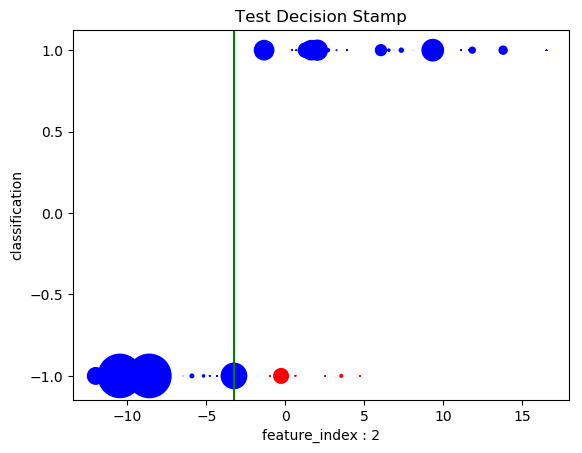

In [51]:
estimator = DecisionStamp()
estimator.fit(X, y, dist)
print(estimator.__dict__())
prediction = estimator.predict(X)
print(f"accuracy: {np.sum(prediction == y)/len(y)}")
print(f"weighted_error: {sum(dist[np.where(prediction != y)])}")

decision_stamp_visualization(X, y, dist, estimator, title_text="Test Decision Stamp")

{'feature_index': 2, 'theta': -3.226097158243836, 'polarity': 1, 'weighted_error': 0.005476890177031034}
accuracy: 0.83
weighted_error: 0.0054768901770310754


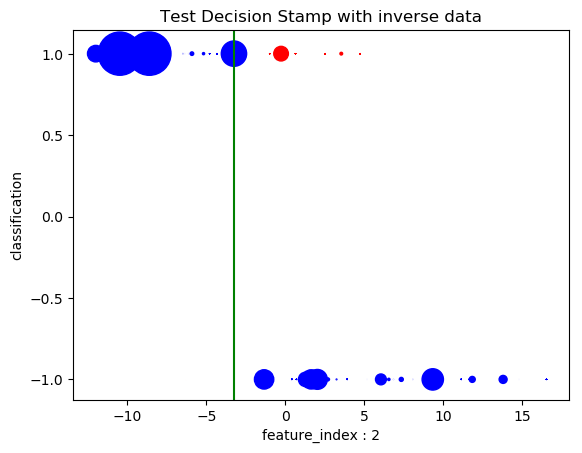

In [52]:
estimator = DecisionStamp()
estimator.fit(X, y*-1, dist)
print(estimator.__dict__())
prediction = estimator.predict(X)
print(f"accuracy: {np.sum(prediction == y*-1)/len(y)}")
print(f"weighted_error: {sum(dist[np.where(prediction != y*-1)])}")

decision_stamp_visualization(X, y*-1, dist, estimator, title_text="Test Decision Stamp with inverse data")

### AdaBoost Exploration

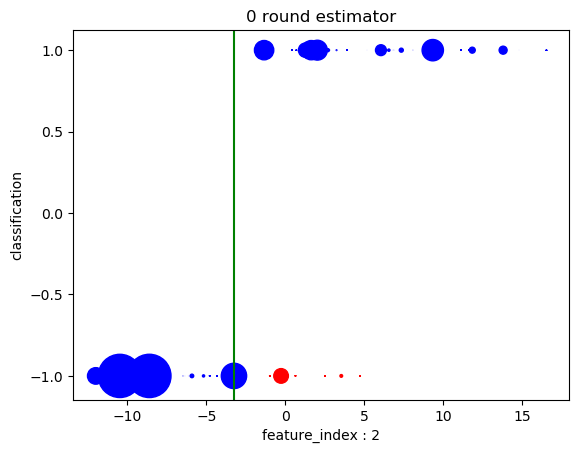

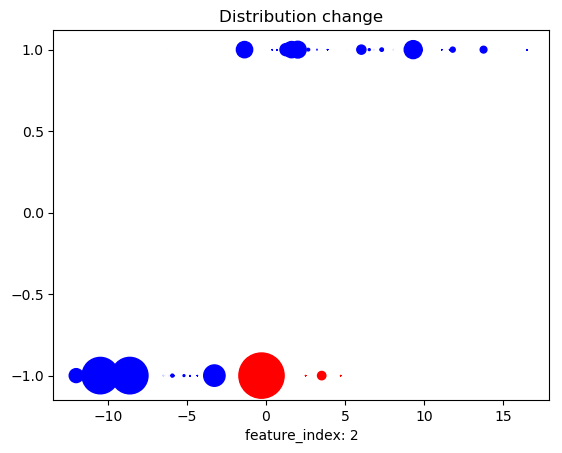

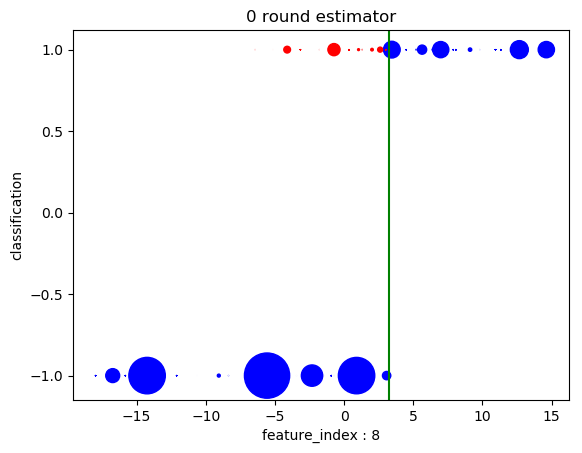

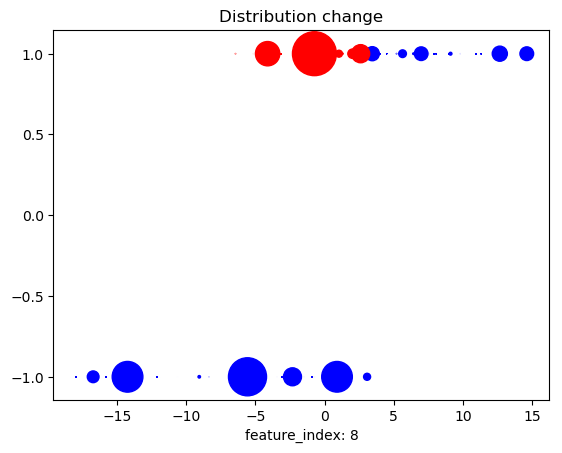

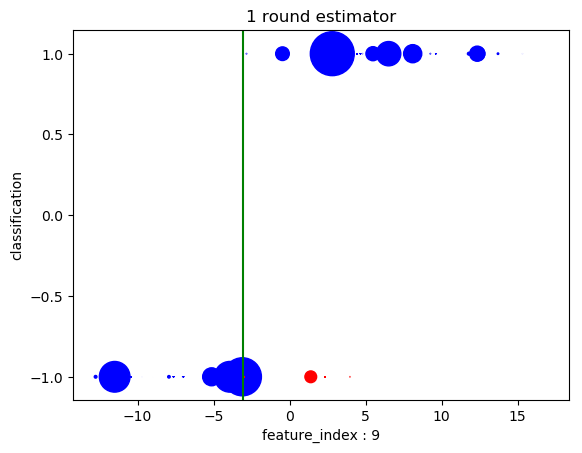

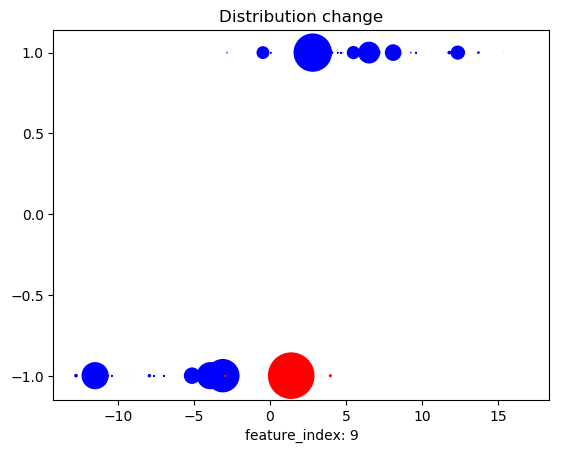

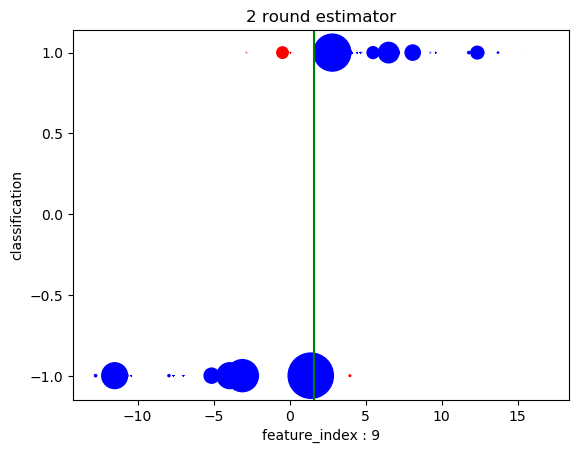

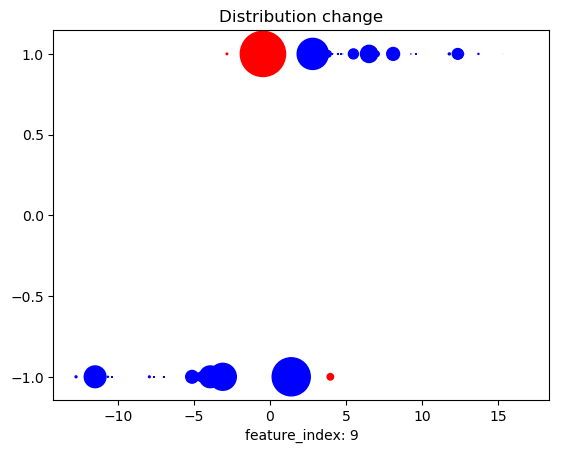

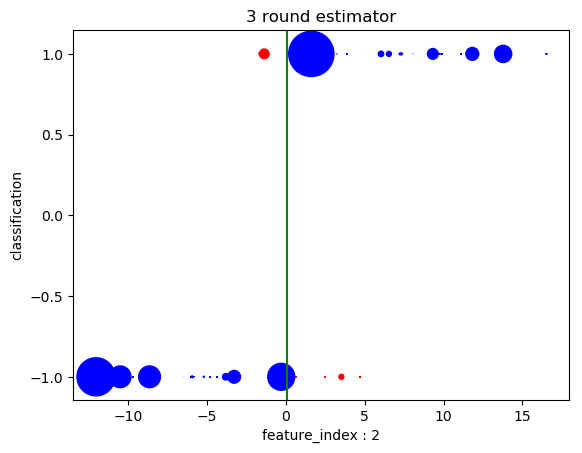

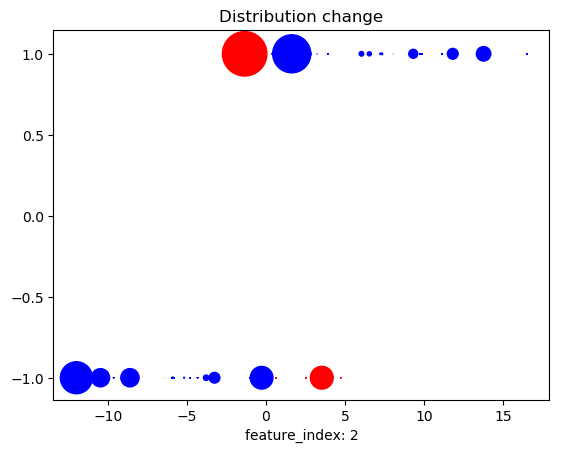

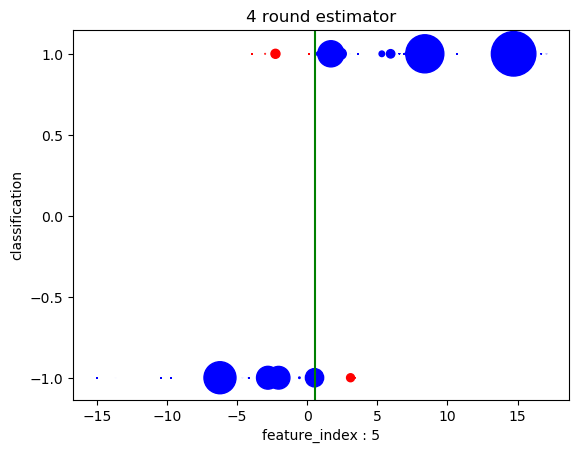

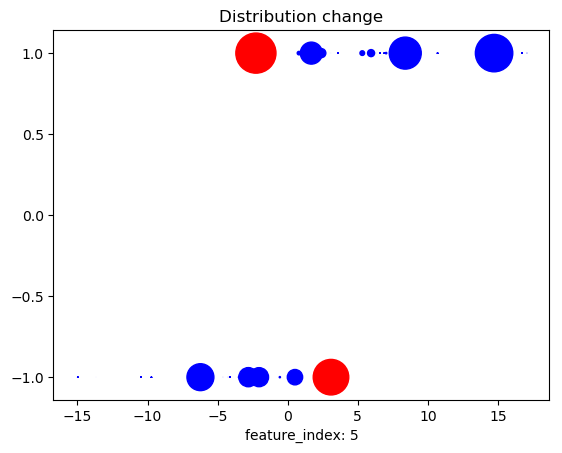

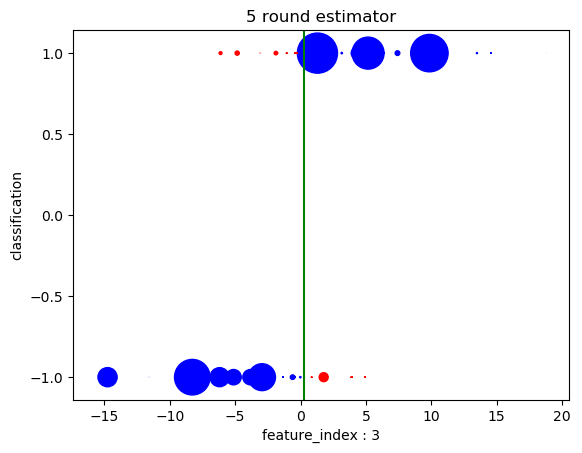

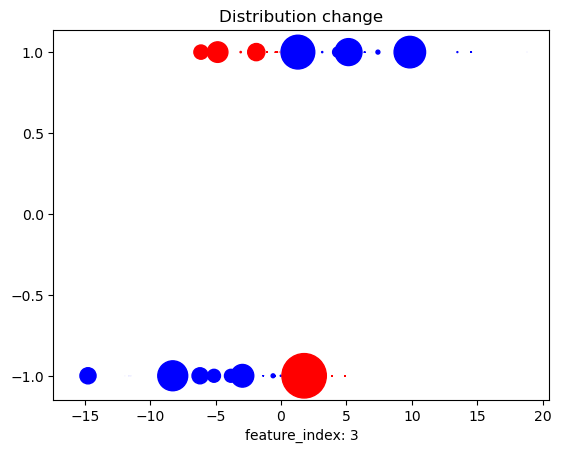

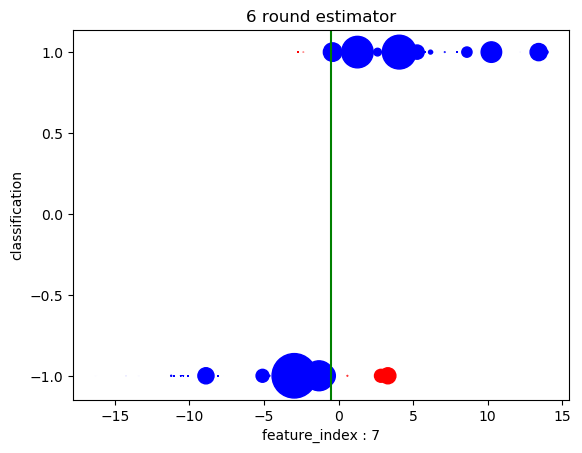

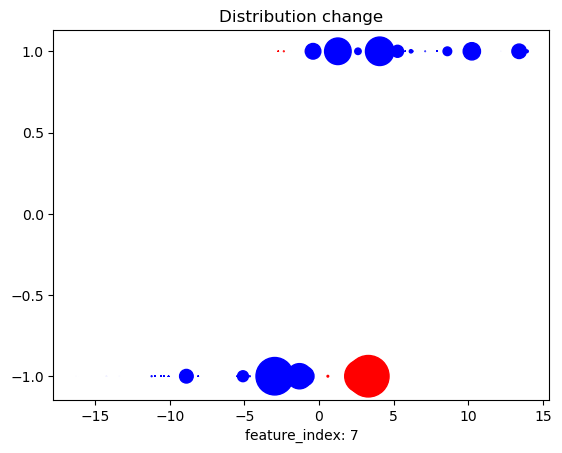

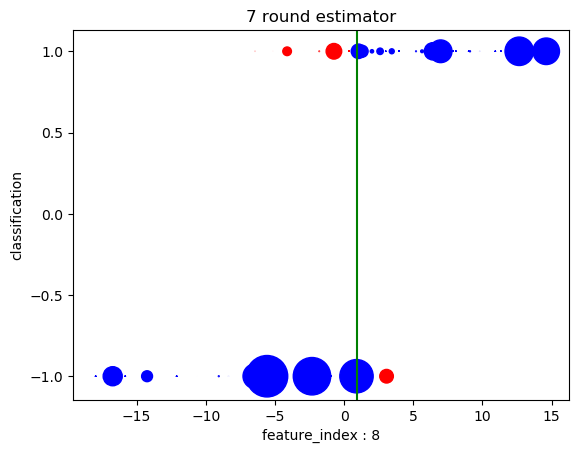

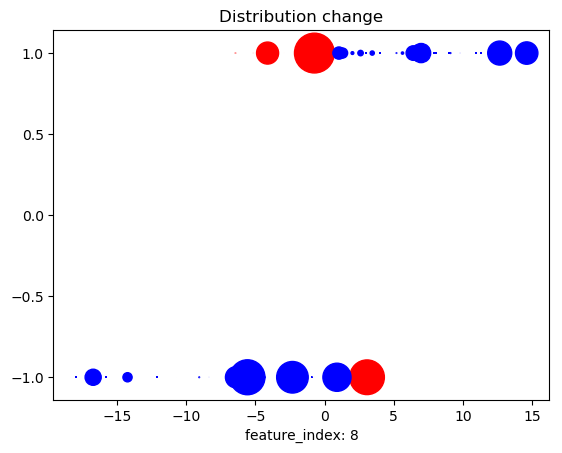

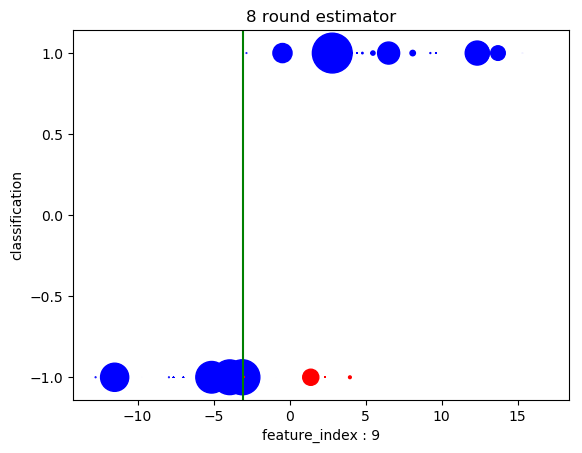

In [60]:
from utils.ada_boost import AdaBoost

ada_est = AdaBoost(10)
ada_est.fit(X, y, dist)


dist_data = [[] for _ in range(len(dist))]
est = ada_est.weak_est[0]
decision_stamp_visualization(X, y, est.dist, est, title_text=f"{0} round estimator")
for i, est in enumerate(ada_est.weak_est[1:]):
    for j in range(len(est.dist)):
        dist_data[j].append(est.dist[j])
    
    prev_est = ada_est.weak_est[i]
    fig = plt.figure()
    prediction = prev_est.predict(X)
    color = np.array(["r"]*len(y))
    color[np.where(prediction == y)] = "b"
    plt.scatter(X[:, prev_est.feature_index], y, s=np.sqrt(est.dist)*1500, color=color)
    plt.title("Distribution change")
    plt.xlabel(f"feature_index: {prev_est.feature_index}")
    plt.show()
    
    decision_stamp_visualization(X, y, est.dist, est, title_text=f"{i} round estimator")
    # print(f"feature index: {est.feature_index}")
dist_data = np.array(dist_data)
# print(ada_est.alphas[0])

In [33]:
number_of_rounds = 1000
ada_est = AdaBoost(number_of_rounds)
ada_est.fit(X, y, dist)

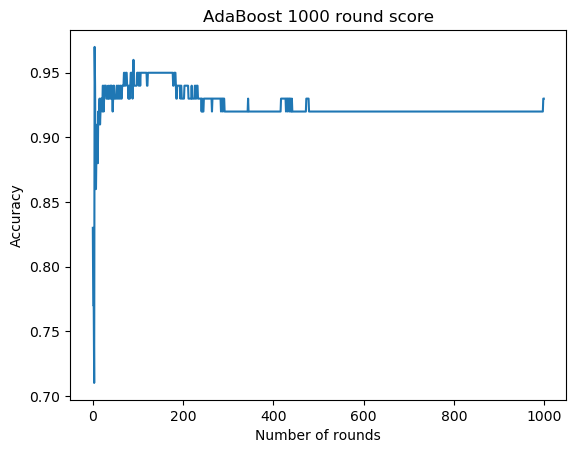

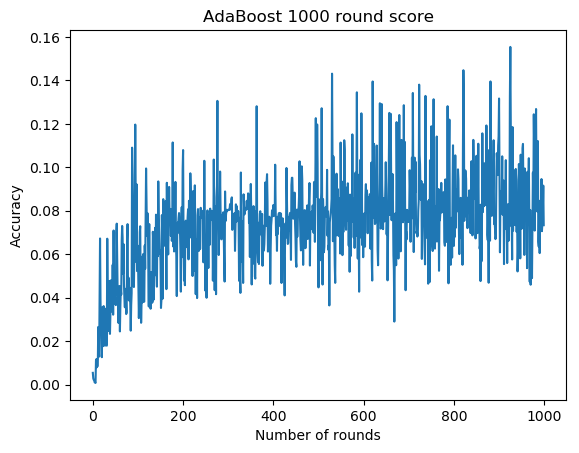

In [34]:
fig = plt.figure()
plt.plot(range(0, ada_est.num_of_est), ada_est.scores)
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.title(f"AdaBoost {number_of_rounds} round score")
plt.show()

fig = plt.figure()
plt.plot(range(0, ada_est.num_of_est), ada_est.weighted_errors)
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.title(f"AdaBoost {number_of_rounds} round score")
plt.show()


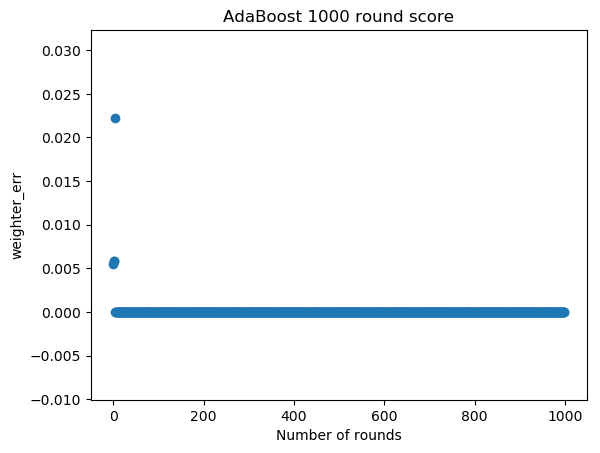

In [35]:
weighted_err = []
for i in range(1, number_of_rounds+1):
    weighted_err.append(np.sum((ada_est.predict(X, num_of_est=i) != y)*dist))

fig = plt.figure()
plt.scatter(range(0, ada_est.num_of_est), weighted_err)
plt.xlabel("Number of rounds")
plt.ylabel("weighter_err")
plt.title(f"AdaBoost {number_of_rounds} round score")
plt.show()


In [53]:
def get_pred_metrics(y: np.ndarray, pred: np.ndarray):
    """Get the classification metrics."""
    TP = np.sum(np.multiply(((pred) == y).astype("int"), (y == 1).astype("int")))
    TN = np.sum(np.multiply(((pred) == y).astype("int"), (y == -1).astype("int")))
    FP = np.sum(np.multiply(((pred) != y).astype("int"), (y == 1).astype("int")))
    FN = np.sum(np.multiply(((pred) != y).astype("int"), (y == -1).astype("int")))
    return(TP, FP, TN, FN)


In [54]:
for i in range(1, number_of_rounds+1, number_of_rounds//5):
    print(get_pred_metrics(y, ada_est.predict(X, num_of_est=i)))

(53, 2, 30, 15)
(48, 7, 45, 0)
(47, 8, 45, 0)
(47, 8, 45, 0)
(47, 8, 45, 0)


### Haar feature building blocks

In [8]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from utils.feature_extraction import get_integral_image


def show_image_side_by_side(image: np.ndarray, i_image: np.ndarray, title_text:str="Two side by side images"):
    fig = plt.figure()
    fig.suptitle(title_text)
    ax1 = plt.subplot(221)
    ax1.imshow(image, interpolation="none")
    ax2 = plt.subplot(222)
    ax2.imshow(i_image, interpolation="none")
    fig.show()

In [9]:
def get_sum_from_i_image(x, y, w, h, i_image):
    i_image_padded = np.pad(i_image, ((1,0), (1, 0)), constant_values=(0))
    A = i_image_padded[x, y]
    B = i_image_padded[x, y+w]
    C = i_image_padded[x+h, y]
    D = i_image_padded[x+h, y+w]
    return D + A - ( B + C )

def get_v_edge_feature(x, y, w, h, i_image):
    return get_sum_from_i_image(x, y, w, h, i_image) - get_sum_from_i_image(x, y+w, w, h, i_image)

def get_h_edge_feature(x, y, w, h, i_image):
    return get_sum_from_i_image(x, y, w, h, i_image) - get_sum_from_i_image(x+h, y, w, h, i_image)

def get_v_band_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x, y+2*w, w, h, i_image))
    black_area = get_sum_from_i_image(x, y+w, w, h, i_image)
    return  white_area - black_area 

def get_h_band_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x+2*h, y, w, h, i_image)) 
    black_area = get_sum_from_i_image(x+h, y, w, h, i_image)
    return white_area - black_area

def get_slant_edge_feature(x, y, w, h, i_image):
    white_area = (get_sum_from_i_image(x, y, w, h, i_image) + get_sum_from_i_image(x+h, y+w, w, h, i_image))
    black_area = (get_sum_from_i_image(x+h, y, w, h, i_image) + get_sum_from_i_image(x, y+w, w, h, i_image))
    return white_area - black_area 


/home/avashist/Viola-Jones_Algorithm/.env/lib/python3.8/site-packages/matplotlib/figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


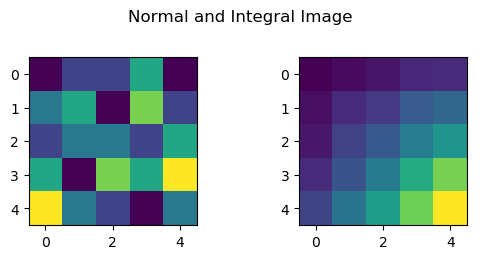

In [10]:
test_image = np.array([[1, 2, 2, 4, 1], [3, 4, 1, 5, 2], [2, 3, 3, 2, 4], [4, 1, 5, 4, 6], [6, 3, 2, 1, 3]])
test_i_image = get_integral_image(test_image)
show_image_side_by_side(test_image, test_i_image, "Normal and Integral Image")

In [11]:
print(test_image)
print(test_i_image)
assert 10 == get_sum_from_i_image(0, 0, 2, 2, test_i_image)
assert 14 == get_sum_from_i_image(2, 2, 2, 2, test_i_image)
assert -2 == get_v_edge_feature(0, 0, 1, 2, test_i_image)
assert 0 == get_h_edge_feature(0, 0, 2, 2, test_i_image)
assert -3 == get_h_edge_feature(0, 1, 2, 2, test_i_image)
assert 0 == get_h_edge_feature(1, 1, 2, 2, test_i_image)
assert 1 == get_v_band_feature(0, 0, 1, 2, test_i_image)
assert 12 == get_v_band_feature(0, 1, 1, 2, test_i_image)
assert 1 == get_h_band_feature(0, 0, 2, 1, test_i_image)
assert 7 == get_h_band_feature(1, 0, 2, 1, test_i_image)
assert 2 == get_slant_edge_feature(0, 0, 2, 2, test_i_image)
assert 1 == get_slant_edge_feature(1, 1, 2, 2, test_i_image)

get_v_edge_feature(2, 1, 2, 2, test_i_image)

[[1 2 2 4 1]
 [3 4 1 5 2]
 [2 3 3 2 4]
 [4 1 5 4 6]
 [6 3 2 1 3]]
[[ 1  3  5  9 10]
 [ 4 10 13 22 25]
 [ 6 15 21 32 39]
 [10 20 31 46 59]
 [16 29 42 58 74]]


-4

In [12]:
row, col = test_i_image.shape
filter_width, filter_height = 2, 3
max_width, max_height = col-2*filter_width+1, row-2*filter_height+1
print(col, row)
print(max_width, max_height)
for i in range(max_height):
    for j in range(max_width):
        print(i, j, get_slant_edge_feature(i, j, filter_width, filter_height, test_i_image))


5 5
2 0


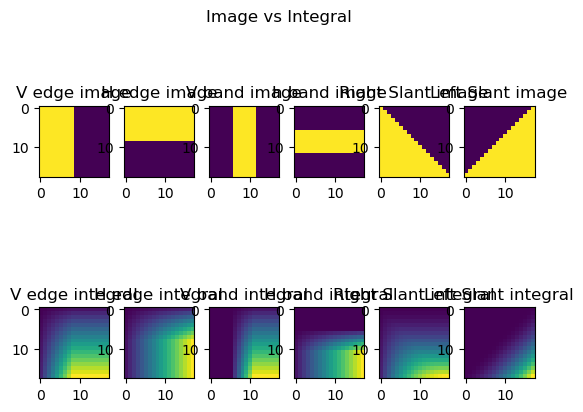

In [13]:
test_h_edge_image = np.array([[255]*162 + [0]*162]).reshape(18,18)
test_v_edge_image = np.array([[255]*162 + [0]*162]).reshape(18,18).T
test_h_band_image = np.array([0]*108 + [255]*108 + [0]*108 ).reshape(18, 18)
test_v_band_image = np.array([0]*108 + [255]*108 + [0]*108 ).reshape(18, 18).T
test_left_slant_image = np.rot90(np.tri(18, 18)*225).T
test_right_slant_image = (np.triu(np.ones((18, 18)))*225).T

test_h_edge_i_image = get_integral_image(test_h_edge_image)
test_v_edge_i_image = get_integral_image(test_v_edge_image)
test_h_band_i_image = get_integral_image(test_h_band_image)
test_v_band_i_image = get_integral_image(test_v_band_image)
test_left_slant_i_image = get_integral_image(test_left_slant_image)
test_right_slant_i_image = get_integral_image(test_right_slant_image)


fig, axes = plt.subplots(2, 6)
fig.suptitle("Image vs Integral")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[1, 0].imshow(test_v_edge_i_image)
axes[1, 0].title.set_text("V edge integral")
axes[0, 1].imshow(test_h_edge_image)
axes[0, 1].title.set_text("H edge image")
axes[1, 1].imshow(test_h_edge_i_image)
axes[1, 1].title.set_text("H edge integral")
axes[0, 2].imshow(test_v_band_image)
axes[0, 2].title.set_text("V band image")
axes[1, 2].imshow(test_v_band_i_image)
axes[1, 2].title.set_text("V band integral")
axes[0, 3].imshow(test_h_band_image)
axes[0, 3].title.set_text("h band image")
axes[1, 3].imshow(test_h_band_i_image)
axes[1, 3].title.set_text("H band integral")
axes[0, 4].imshow(test_right_slant_image)
axes[0, 4].title.set_text("Right Slant image")
axes[1, 4].imshow(test_right_slant_i_image)
axes[1, 4].title.set_text("Right Slant integral")
axes[0, 5].imshow(test_left_slant_image)
axes[0, 5].title.set_text("Left Slant image")
axes[1, 5].imshow(test_left_slant_i_image)
axes[1, 5].title.set_text("Left Slant integral")
plt.show()

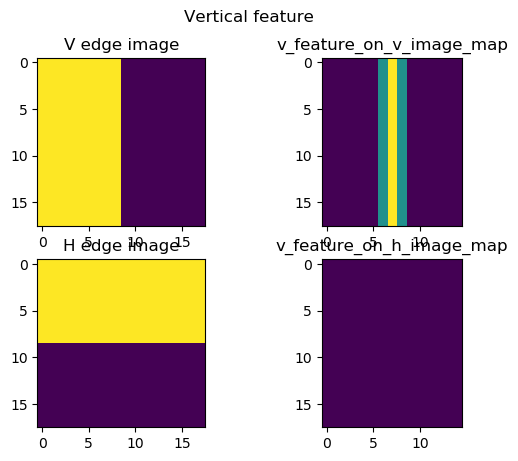

In [14]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 1
max_width, max_height = col-2*filter_width+1, row-1*filter_height+1
v_feature_on_v_image_map = np.zeros((max_height, max_width))
v_feature_on_h_image_map = np.zeros(( max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_feature_on_v_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_feature_on_h_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
fig, axes = plt.subplots(2, 2)
fig.suptitle("Vertical feature")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[0, 1].imshow(v_feature_on_v_image_map)
axes[0, 1].title.set_text("v_feature_on_v_image_map")
axes[1, 0].imshow(test_h_edge_image)
axes[1, 0].title.set_text("H edge image")
axes[1, 1].imshow(v_feature_on_h_image_map)
axes[1, 1].title.set_text("v_feature_on_h_image_map")
plt.show()

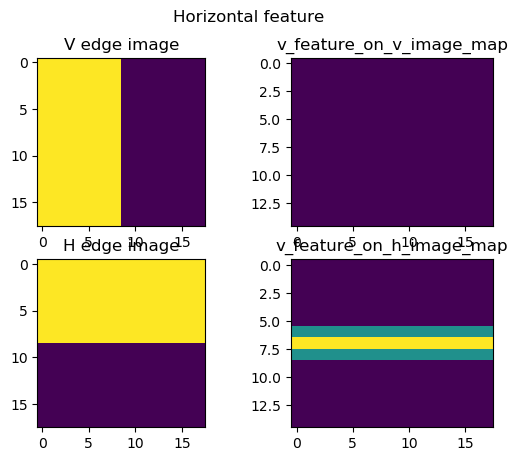

In [15]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 1, 2
max_width, max_height = col-1*filter_width+1, row-2*filter_height+1
h_feature_on_v_image_map = np.zeros((max_height, max_width))
h_feature_on_h_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        h_feature_on_v_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        h_feature_on_h_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
fig, axes = plt.subplots(2, 2)
fig.suptitle("Horizontal feature")
axes[0, 0].imshow(test_v_edge_image)
axes[0, 0].title.set_text("V edge image")
axes[0, 1].imshow(h_feature_on_v_image_map)
axes[0, 1].title.set_text("v_feature_on_v_image_map")
axes[1, 0].imshow(test_h_edge_image)
axes[1, 0].title.set_text("H edge image")
axes[1, 1].imshow(h_feature_on_h_image_map)
axes[1, 1].title.set_text("v_feature_on_h_image_map")
plt.show()

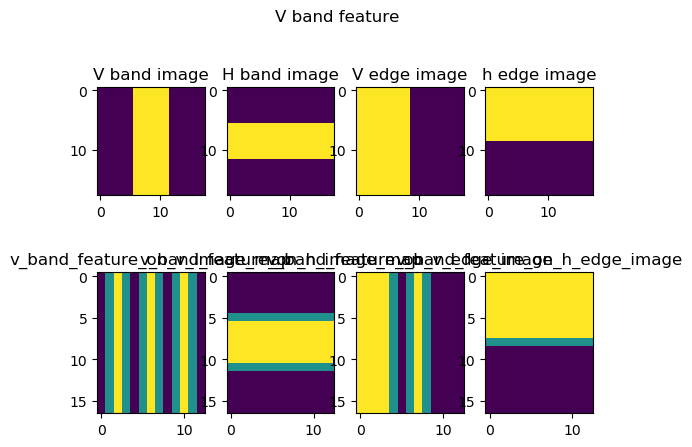

In [16]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 2
max_width, max_height = col-3*filter_width+1, row-1*filter_height+1
v_band_feature_on_v_image_map = np.zeros((max_height, max_width))
v_band_feature_on_h_image_map = np.zeros(( max_height, max_width))
v_band_feature_on_v_band_image_map = np.zeros((max_height, max_width))
v_band_feature_on_h_band_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_v_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_v_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_h_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_h_edge_i_image)
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_v_band_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_h_band_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, test_h_band_i_image)

fig, axes = plt.subplots(2, 4)
fig.suptitle("V band feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(v_band_feature_on_v_band_image_map)
axes[1, 0].title.set_text("v_band_feature_on_v_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(v_band_feature_on_h_band_image_map)
axes[1, 1].title.set_text("v_band_feature_on_h_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(v_band_feature_on_v_image_map)
axes[1, 2].title.set_text("v_band_feature_on_v_edge_image")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(v_band_feature_on_h_image_map)
axes[1, 3].title.set_text("v_band_feature_on_h_edge_image")
plt.show()

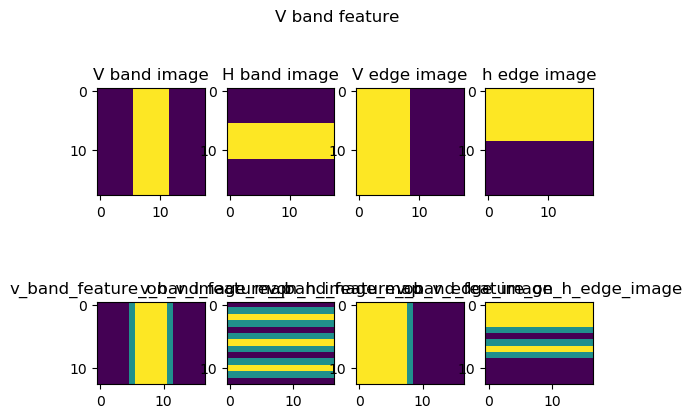

In [17]:
row, col = test_v_edge_i_image.shape
filter_width, filter_height = 2, 2
max_width, max_height = col-1*filter_width+1, row-3*filter_height+1
h_band_feature_on_v_image_map = np.zeros((max_height, max_width))
h_band_feature_on_h_image_map = np.zeros(( max_height, max_width))
h_band_feature_on_v_band_image_map = np.zeros((max_height, max_width))
h_band_feature_on_h_band_image_map = np.zeros(( max_height, max_width))

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_v_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_v_edge_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_h_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_h_edge_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_v_band_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_h_band_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, test_h_band_i_image)

fig, axes = plt.subplots(2, 4)
fig.suptitle("V band feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(h_band_feature_on_v_band_image_map)
axes[1, 0].title.set_text("v_band_feature_on_v_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(h_band_feature_on_h_band_image_map)
axes[1, 1].title.set_text("v_band_feature_on_h_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(h_band_feature_on_v_image_map)
axes[1, 2].title.set_text("v_band_feature_on_v_edge_image")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(h_band_feature_on_h_image_map)
axes[1, 3].title.set_text("v_band_feature_on_h_edge_image")
plt.show()

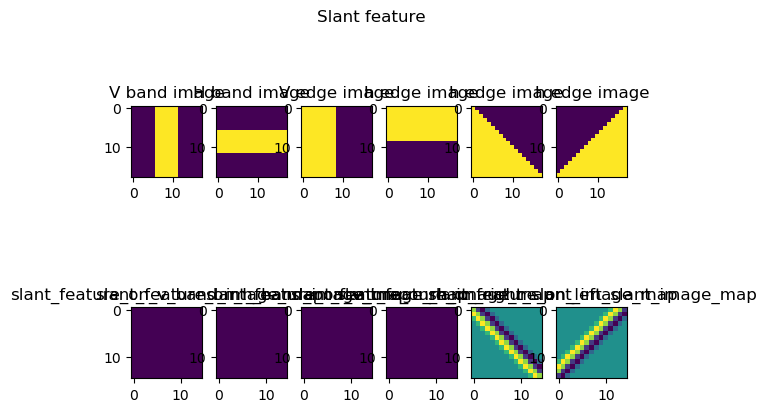

In [18]:
row, col = test_v_edge_i_image.shape

filter_width, filter_height = 2, 2
max_width, max_height = col-2*filter_width+1, row-2*filter_height+1


slant_feature_on_v_image_map = np.zeros((max_height, max_width))
slant_feature_on_h_image_map = np.zeros((max_height, max_width))
slant_feature_on_v_band_image_map = np.zeros((max_height, max_width))
slant_feature_on_h_band_image_map = np.zeros(( max_height, max_width))
slant_feature_on_left_slant_image_map = np.zeros((max_height, max_width))
slant_feature_on_right_slant_image_map = np.zeros((max_height, max_width))


for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_v_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_v_edge_i_image)

for i in range(max_width):
    for j in range(max_width):
        slant_feature_on_h_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_h_edge_i_image)

for i in range(max_width):
    for j in range(max_width):
        slant_feature_on_v_band_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_v_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_h_band_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_h_band_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_left_slant_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_left_slant_i_image)

for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_right_slant_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, test_right_slant_i_image)

fig, axes = plt.subplots(2, 6)
fig.suptitle("Slant feature")
axes[0, 0].imshow(test_v_band_image)
axes[0, 0].title.set_text("V band image")
axes[1, 0].imshow(slant_feature_on_v_band_image_map)
axes[1, 0].title.set_text("slant_feature_on_v_band_image_map")
axes[0, 1].imshow(test_h_band_image)
axes[0, 1].title.set_text("H band image")
axes[1, 1].imshow(slant_feature_on_h_band_image_map)
axes[1, 1].title.set_text("slant_feature_on_h_band_image_map")
axes[0, 2].imshow(test_v_edge_image)
axes[0, 2].title.set_text("V edge image")
axes[1, 2].imshow(slant_feature_on_v_image_map)
axes[1, 2].title.set_text("slant_feature_on_v_image_map")
axes[0, 3].imshow(test_h_edge_image)
axes[0, 3].title.set_text("h edge image")
axes[1, 3].imshow(slant_feature_on_h_image_map)
axes[1, 3].title.set_text("slant_feature_on_h_image_map")
axes[0, 4].imshow(test_right_slant_image)
axes[0, 4].title.set_text("h edge image")
axes[1, 4].imshow(slant_feature_on_right_slant_image_map)
axes[1, 4].title.set_text("slant_feature_on_right_slant_image_map")
axes[0, 5].imshow(test_left_slant_image)
axes[0, 5].title.set_text("h edge image")
axes[1, 5].imshow(slant_feature_on_left_slant_image_map)
axes[1, 5].title.set_text("slant_feature_on_left_slant_image_map")
plt.show()

Text(0.5,0.98,'Feature map on a face')

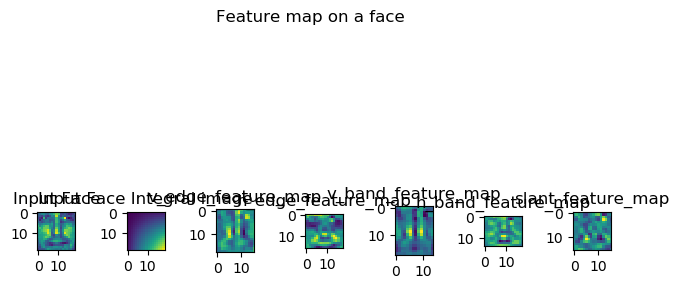

In [19]:
from typing import Final, Tuple, Optional
face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)
i_image = get_integral_image(image)

feature_width, feature_height = 2, 2
row, col = i_image.shape

max_width, max_height = col-2*filter_width+1, row-1*filter_height+1
v_edge_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_edge_feature_on_face_image_map[i, j] = get_v_edge_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-1*filter_width+1, row-2*filter_height+1
h_edge_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        h_edge_feature_on_face_image_map[i, j] = get_h_edge_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-3*filter_width+1, row-1*filter_height+1
v_band_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        v_band_feature_on_face_image_map[i, j] = get_v_band_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-1*filter_width+1, row-3*filter_height+1
h_band_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        h_band_feature_on_face_image_map[i, j] = get_h_band_feature(i, j, filter_width, filter_height, i_image)

max_width, max_height = col-2*filter_width+1, row-2*filter_height+1
slant_feature_on_face_image_map = np.zeros((max_height, max_width))
for i in range(max_height):
    for j in range(max_width):
        slant_feature_on_face_image_map[i, j] = get_slant_edge_feature(i, j, filter_width, filter_height, i_image)

fig, axes = plt.subplots(1, 7)
fig.tight_layout()

axes[0].imshow(image, interpolation="none")
axes[0].title.set_text("Input Face")
axes[1].imshow(i_image, interpolation="none")
axes[1].title.set_text("Input Face Integral image")
axes[2].imshow(v_edge_feature_on_face_image_map, interpolation="none")
axes[2].title.set_text("v_edge_feature_map")
axes[3].imshow(h_edge_feature_on_face_image_map, interpolation="none")
axes[3].title.set_text("h_edge_feature_map")
axes[4].imshow(v_band_feature_on_face_image_map, interpolation="none")
axes[4].title.set_text("v_band_feature_map")
axes[5].imshow(h_band_feature_on_face_image_map, interpolation="none")
axes[5].title.set_text("h_band_feature_map")
axes[6].imshow(slant_feature_on_face_image_map, interpolation="none")
axes[6].title.set_text("slant_feature_map")
fig.suptitle("Feature map on a face")

### Haar Feature Extraction

In [20]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from typing import Final, Tuple, Final

from utils.feature_extraction import get_integral_image

18 16
-256 276
18 14
188 886


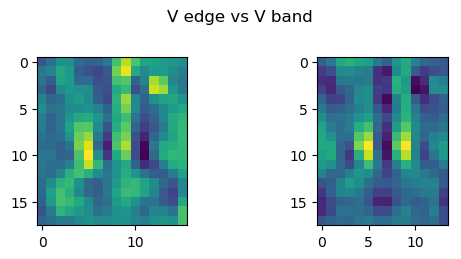

In [21]:

face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)
i_image = get_integral_image(image)

filter_width, filter_height = 2, 2
image_width, image_height = i_image.shape
height_limit, width_limit = image_height-1*filter_height+1, image_width-2*filter_width+1

features = []
for i in range(height_limit):
    for j in range(width_limit):
        features.append(get_v_edge_feature(i, j, filter_width, filter_height, i_image))

v_edge_features = np.array(features).reshape((height_limit, width_limit))

print(height_limit, width_limit)
print(np.min(features), np.max(features))


filter_width, filter_height = 2, 2
image_width, image_height = i_image.shape
height_limit, width_limit = image_height-1*filter_height+1, image_width-3*filter_width+1

features = []
for i in range(height_limit):
    for j in range(width_limit):
        features.append(get_v_band_feature(i, j, filter_width, filter_height, i_image))
        
v_band_features = np.array(features).reshape((height_limit, width_limit))

print(height_limit, width_limit)
print(np.min(features), np.max(features))
show_image_side_by_side(v_edge_features, v_band_features, "V edge vs V band")

In [22]:
print(image[:6, :6])
print(i_image[:9, :9])
print(v_edge_features[:5, :5])

print(f"V edge feature value: {get_v_edge_feature(0, 0, 2, 2, i_image)}")
print((104 + 122 + 90 + 102) - (142 + 159 + 116 + 120))
print(f"H band feature value: {get_h_band_feature(0, 0, 2, 2, i_image)}")
print((104 + 122 + 90 + 102) - (91 + 90 + 85 + 73) + (97 + 63 + 99 + 94))

[[104 122 142 159 162 158]
 [ 90 102 116 120 104  96]
 [ 91  90  81 102  81  74]
 [ 85  73  66 144  79 105]
 [ 97  63  88 100 108 110]
 [ 99  94  85  96 108 105]]
[[ 104  226  368  527  689  847 1014 1191 1376]
 [ 194  418  676  955 1221 1475 1762 2066 2394]
 [ 285  599  938 1319 1666 1994 2368 2791 3230]
 [ 370  757 1162 1687 2113 2546 3022 3546 4091]
 [ 467  917 1410 2035 2569 3112 3678 4297 4939]
 [ 566 1110 1688 2409 3051 3699 4361 5091 5829]
 [ 695 1344 2036 2882 3646 4422 5203 6063 6899]
 [ 839 1604 2429 3421 4342 5273 6176 7159 8092]
 [ 974 1887 2849 3998 5077 6164 7200 8297 9326]]
[[-119  -63   17    4  -71]
 [ -46  -18   64   30  -98]
 [ -54  -96   54   38  -70]
 [ -80 -141   -4   24   14]
 [ -16  -82  -62   11   39]]
V edge feature value: -119
-119
H band feature value: 432
432


In [23]:
def feature_extraction(i_image: np.ndarray) -> np.ndarray:
    
    feature_val = []
    feature_para = []
    row, col = i_image.shape
    max_height, max_width = row+1, col//2+1
    
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-1*feature_height+1, col-2*feature_width+1
            for i in range(0, height_limit):
                for j in range(0, width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_v_edge_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//2+1, col+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row -2*feature_height+1, col -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_h_edge_feature(i, j, feature_width, feature_height, i_image))
            
    max_height, max_width = row+1, col//3+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-1*feature_height+1, col-3*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_v_band_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//3 + 1, col+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-3*feature_height+1, col -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_h_band_feature(i, j, feature_width, feature_height, i_image))

    max_height, max_width = row//2+1, col//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = row-2*feature_height+1, col-2*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    feature_para.append([i, j, feature_width, feature_height])
                    feature_val.append(get_slant_edge_feature(i, j, feature_width, feature_height, i_image))

    return feature_val, feature_para


test_image = np.array([[1, 2, 2, 4, 1],
                    [3, 4, 1, 5, 2],
                    [2, 3, 3, 2, 4],
                    [4, 1, 5, 4, 6],
                    [6, 3, 2, 1, 3],
                    [255, 1, 2, 3, 4]], dtype=np.uint8)

test_i_image = get_integral_image(test_image)
feature_vales, feature_para = feature_extraction(test_i_image)
print(test_i_image.shape)
print(len(feature_vales))
print(test_i_image.shape)

(6, 5)
453
(6, 5)


In [24]:
def get_feature_values(height: int, width: int, feature_index: int ) -> Optional[Tuple[int, int, int, int, str]]:
    val = 0
    max_height, max_width = height+1, width//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-1*feature_height+1, width-2*feature_width+1
            for i in range(0, height_limit):
                for j in range(0, width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Vertical edge feature")
                    val += 1
    max_height, max_width = height//2+1, width+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height -2*feature_height+1, width -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Horizontal edge feature")
                    val += 1

    max_height, max_width = height+1, width//3+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-1*feature_height+1, width -3*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Vertical band feature")
                    val += 1

    max_height, max_width = height//3+1, width+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-3*feature_height+1, width -1*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Horizontal band feature")
                    val += 1

    max_height, max_width = height//2+1, width//2+1
    for feature_width in range(1, max_width):
        for feature_height in range(1, max_height):
            height_limit, width_limit = height-2*feature_height+1, width-2*feature_width+1
            for i in range(height_limit):
                for j in range(width_limit):
                    if val == feature_index:
                        return (i, j, feature_width, feature_height, "Slant feature")
                    val += 1


# print(get_feature_values(19, 19, 63959))

res = { 
        0: (0, 0, 1, 1, 'Vertical edge feature'),
        8988: (0, 8, 3, 16, 'Vertical edge feature'),
        17976: (12, 2, 1, 3, 'Horizontal edge feature'),
        26964: (3, 5, 7, 6, 'Horizontal edge feature'),
        35952: (4, 1, 1, 7, 'Vertical band feature'),
        44940: (0, 0, 6, 11, 'Vertical band feature'),
        53927: (14, 7, 12, 1, 'Horizontal band feature'),
        63927: (3, 1, 9, 6, 'Slant feature'),
        63959: (1, 1, 9, 9, 'Slant feature')
       }
feature_vales, feature_para = feature_extraction(i_image)
print(len(feature_para))
for key in res.keys():
    print(feature_para[key])
    print(get_feature_values(19, 19, key))

63960
[0, 0, 1, 1]
(0, 0, 1, 1, 'Vertical edge feature')
[0, 8, 3, 16]
(0, 8, 3, 16, 'Vertical edge feature')
[12, 2, 1, 3]
(12, 2, 1, 3, 'Horizontal edge feature')
[3, 5, 7, 6]
(3, 5, 7, 6, 'Horizontal edge feature')
[4, 1, 1, 7]
(4, 1, 1, 7, 'Vertical band feature')
[0, 0, 6, 11]
(0, 0, 6, 11, 'Vertical band feature')
[14, 7, 12, 1]
(14, 7, 12, 1, 'Horizontal band feature')
[3, 1, 9, 6]
(3, 1, 9, 6, 'Slant feature')
[1, 1, 9, 9]
(1, 1, 9, 9, 'Slant feature')


In [33]:
face_file: Final = "../dataset/trainset/faces/face00001.png"

image = imageio.imread(face_file)
i_image = get_integral_image(image)
features, feature_para = feature_extraction(i_image)
for i in range(len(features)):
    x, y, w, h, feature_type = get_feature_values(19, 19, i)
    if feature_type == "Vertical edge feature":
        assert features[i] == np.sum(image[x:x+h, y:y+w], dtype=np.int32) - np.sum(image[x:x+h, y+w:y+2*w], dtype=np.int32)
    elif feature_type == "Horizontal edge feature":
        assert features[i] == np.sum(image[x:x+h, y:y+w], dtype=np.int32) - np.sum(image[x+h:x+2*h, y:y+w], dtype=np.int32)
    elif feature_type == "Vertical band feature":
        assert features[i] == np.sum(image[x:x+h, y:y+w], dtype=np.int32) +  np.sum(image[x:x+h, y+2*w:y+3*w]) - np.sum(image[x:x+h, y+w:y+2*w], dtype=np.int32)
    elif feature_type == "Horizontal band feature":
        assert features[i] == np.sum(image[x:x+h, y:y+w], dtype=np.int32) + np.sum(image[x+2*h:x+3*h, y:y+w], dtype=np.int32) - np.sum(image[x+h:x+2*h, y:y+w], dtype=np.int32)
    else:
        assert features[i] == np.sum(image[x:x+h, y:y+w], dtype=np.int32) + np.sum(image[x+h:x+2*h, y+w:y+2*w], dtype=np.int32) - np.sum(image[x:x+h, y+w:y+2*w], dtype=np.int32) - np.sum(image[x+h:x+2*h, y:y+w], dtype=np.int32)


### Feature Visualization

/home/avashist/Viola-Jones_Algorithm/.env/lib/python3.8/site-packages/matplotlib/figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


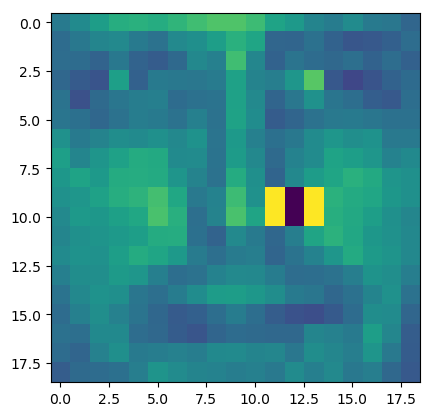

In [34]:
from utils.ada_boost import AdaBoost
def draw_feature(base_image: np.ndarray, feature_index:int) -> np.ndarray:
    row, col = base_image.shape
    x, y, w, h, feature_type = get_feature_values(row, col, feature_index)
    if feature_type == "Vertical edge feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x:x+h, y+w:y+2*w] = 0

    elif feature_type == "Horizontal edge feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+2*h, y:y+w] = 0
        
    elif feature_type == "Vertical band feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x:x+h, y+w:y+2*w] = 0
        base_image[x:x+h, y+2*w:y+3*w] = 255

    elif feature_type == "Horizontal band feature":
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+2*h, y:y+w] = 0
        base_image[x+2*h:x+3*w, y:y+w] = 255
    else:
        base_image[x:x+h, y:y+w] = 255
        base_image[x+h:x+2*h, y:y+w] = 0
        base_image[x:x+h, y+w:y+2*w] = 0
        base_image[x+h:x+2*h, y+w:y+2*w] = 255
        
        
    return base_image

face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)
fig = plt.figure()
plt.imshow(draw_feature(image.copy(), 34687))
fig.show()

### Face detection and model training

In [35]:
from typing import Final
def load_file(file_path: str) -> np.ndarray:
    return np.loadtxt(file_path, dtype="int", delimiter=",")

TRAIN_PATH: Final = "../.tmp_dataset/train_data.csv"
train_matrix = load_file(TRAIN_PATH)

In [64]:
X, y = train_matrix[:1000, :-1], train_matrix[:1000, -1]

In [65]:
clf = AdaBoost(10)

def round_logging(clf: AdaBoost, round: int) -> None:
    """Logs the status of reach round."""
    print(f"Completing training for round {round}")
    print(f"{clf.weak_est[-1].__dict__()}")

clf.fit(X, y, round_call_back=round_logging)

Completing training for round 1
{'feature_index': 3338, 'theta': -171.5, 'polarity': 1, 'weighted_error': 0.16689066756267312}
Completing training for round 2
{'feature_index': 6863, 'theta': -87.5, 'polarity': 1, 'weighted_error': 0.19115744418794894}
Completing training for round 3
{'feature_index': 24911, 'theta': -52.5, 'polarity': 1, 'weighted_error': 0.23233001971945683}
Completing training for round 4
{'feature_index': 17504, 'theta': -16.5, 'polarity': 1, 'weighted_error': 0.21864873816933583}
Completing training for round 5
{'feature_index': 23587, 'theta': -58.5, 'polarity': 1, 'weighted_error': 0.21818993153536898}
Completing training for round 6
{'feature_index': 9120, 'theta': -55.5, 'polarity': 1, 'weighted_error': 0.20447859152860395}
Completing training for round 7
{'feature_index': 59590, 'theta': -95.0, 'polarity': 1, 'weighted_error': 0.21586937061764178}
Completing training for round 8
{'feature_index': 907, 'theta': -3.5, 'polarity': 1, 'weighted_error': 0.24513595

In [67]:
def get_pred_metrics(y: np.ndarray, pred: np.ndarray):
    """Get the classification metrics."""
    TP = np.sum(np.multiply(((pred) == y).astype("int"), (y == 1).astype("int")))
    TN = np.sum(np.multiply(((pred) == y).astype("int"), (y == -1).astype("int")))
    FP = np.sum(np.multiply(((pred) != y).astype("int"), (y == 1).astype("int")))
    FN = np.sum(np.multiply(((pred) != y).astype("int"), (y == -1).astype("int")))
    return(TP, FP, TN, FN)

for i in range(1, 11):
    pred = clf.predict(X, num_of_est=i)
    TP, FP, TN, FN = get_pred_metrics(y, clf.predict(X, num_of_est=i))
    print(f"num_of_clf: {i} accuracy: {(TP + TN)/(TP+FP+TN+FN)} recall: {TP/(TP + FN)} precision: {TP/(TP + FP)}")

num_of_clf: 1 accuracy: 0.833 recall: 0.7996389891696751 precision: 0.8877755511022044
num_of_clf: 2 accuracy: 0.838 recall: 0.9331619537275064 precision: 0.7274549098196392
num_of_clf: 3 accuracy: 0.706 recall: 0.985781990521327 precision: 0.4168336673346693
num_of_clf: 4 accuracy: 0.831 recall: 0.9634831460674157 precision: 0.687374749498998
num_of_clf: 5 accuracy: 0.808 recall: 0.9935691318327974 precision: 0.6192384769539078
num_of_clf: 6 accuracy: 0.761 recall: 1.0 precision: 0.5210420841683366
num_of_clf: 7 accuracy: 0.679 recall: 1.0 precision: 0.35671342685370744
num_of_clf: 8 accuracy: 0.815 recall: 1.0 precision: 0.6292585170340681
num_of_clf: 9 accuracy: 0.741 recall: 1.0 precision: 0.48096192384769537
num_of_clf: 10 accuracy: 0.719 recall: 1.0 precision: 0.43687374749499


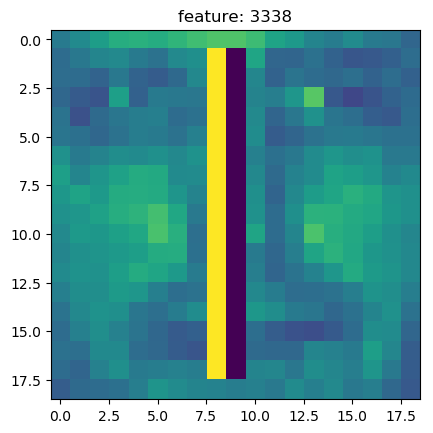

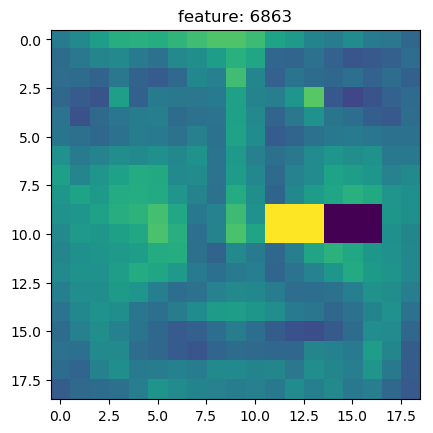

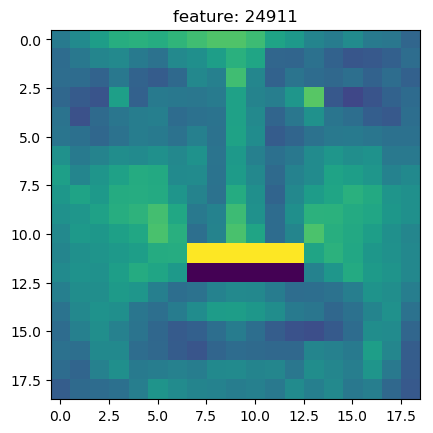

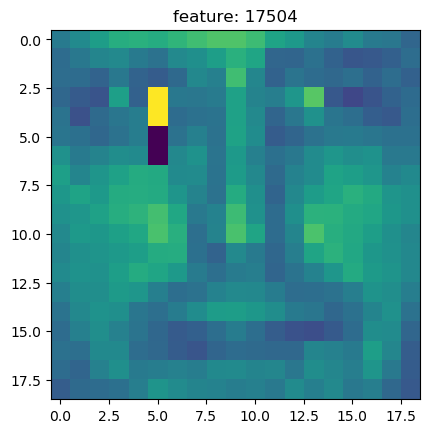

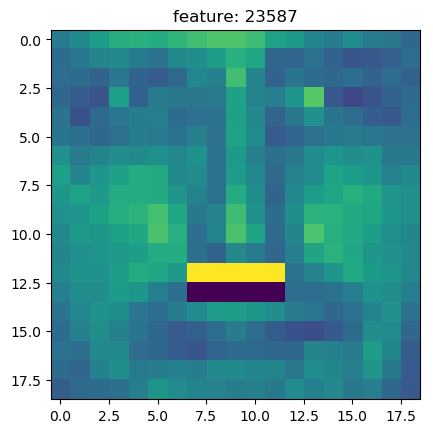

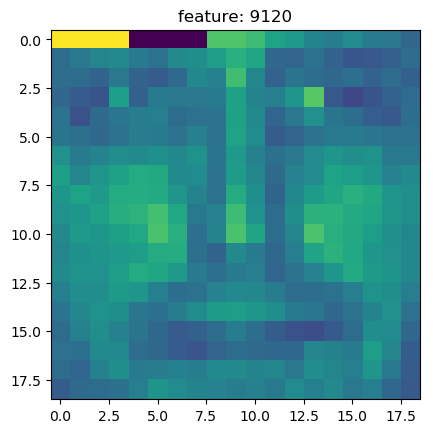

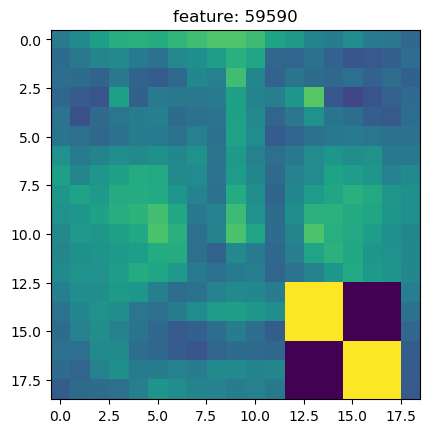

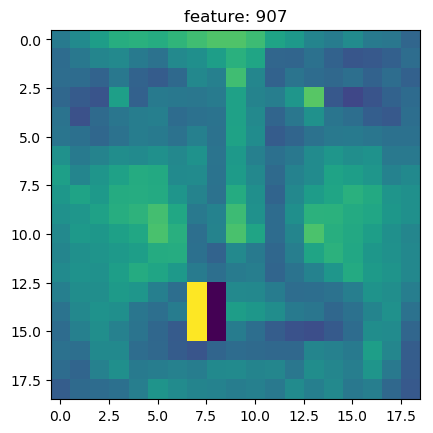

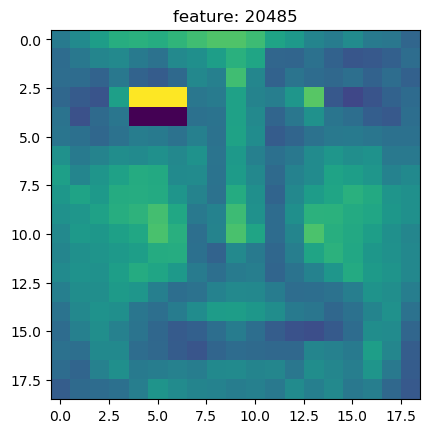

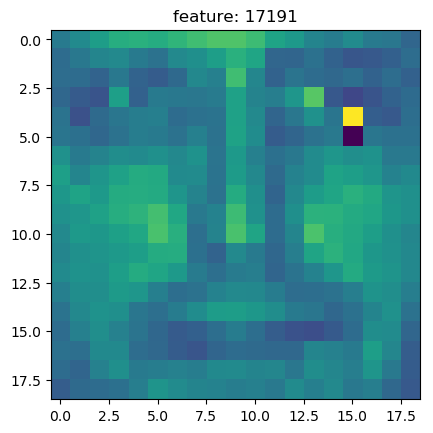

In [70]:
import imageio.v2 as imageio
from utils.visualization import draw_feature

face_file: Final = "../dataset/trainset/faces/face00001.png"
image = imageio.imread(face_file)

for i, est in enumerate(clf.weak_est):
    fig = plt.figure()
    plt.imshow(draw_feature(image.copy(), est.feature_index))
    plt.title(f"feature: {est.feature_index}")
    fig.show()

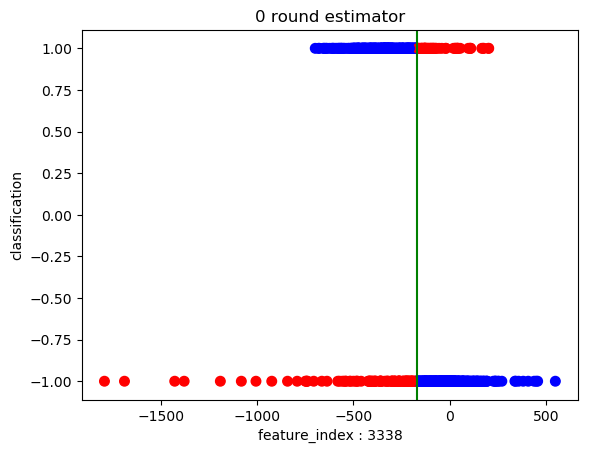

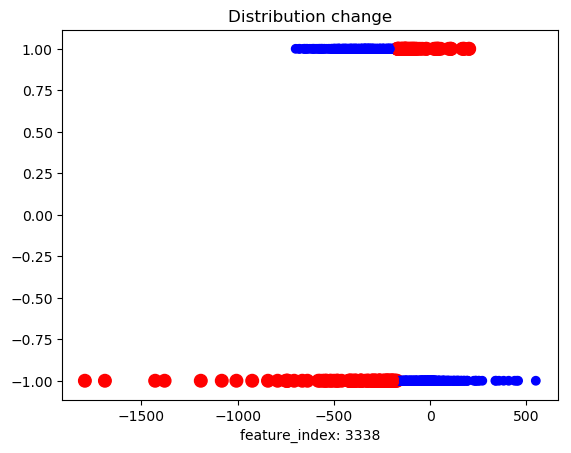

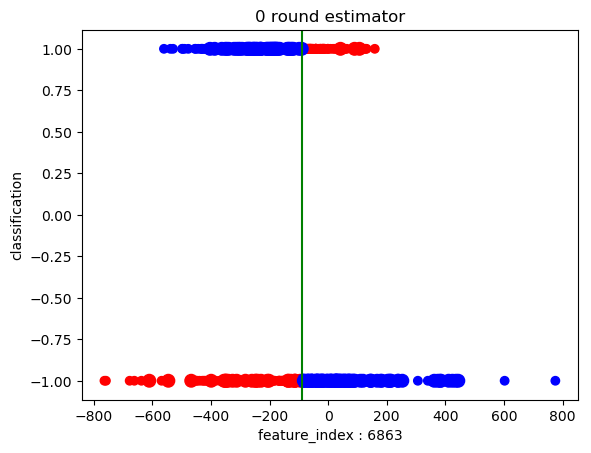

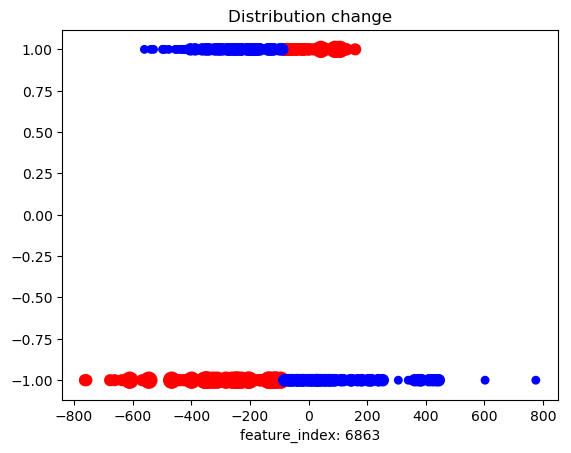

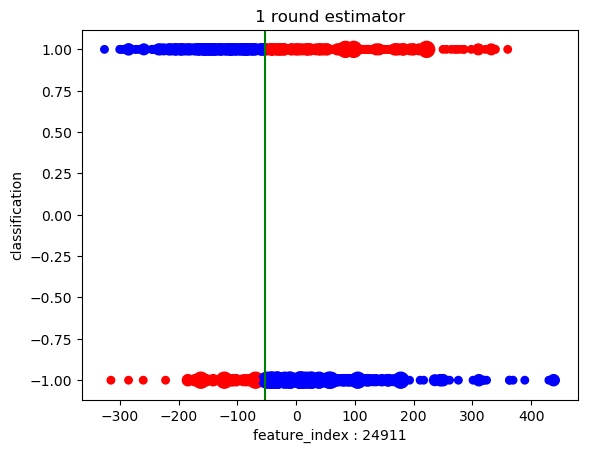

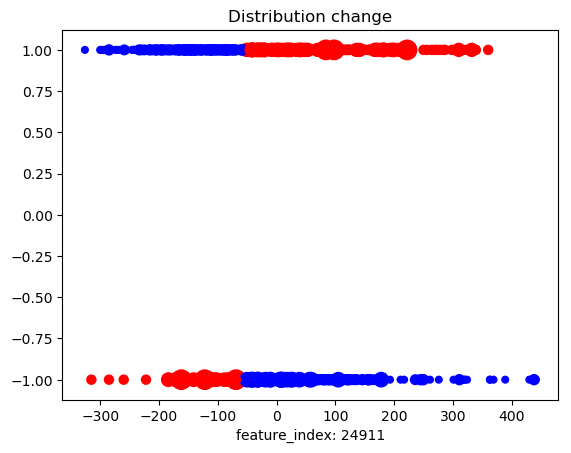

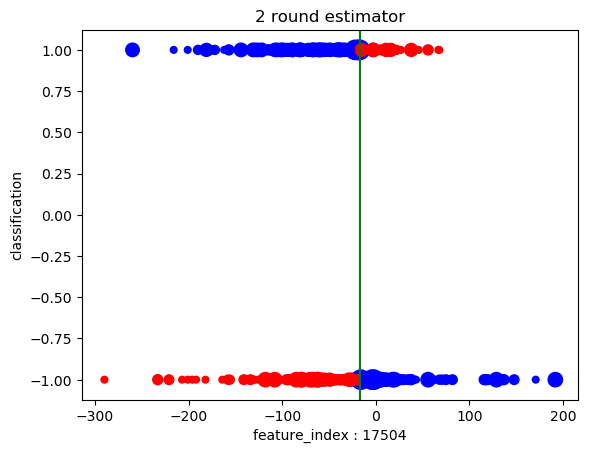

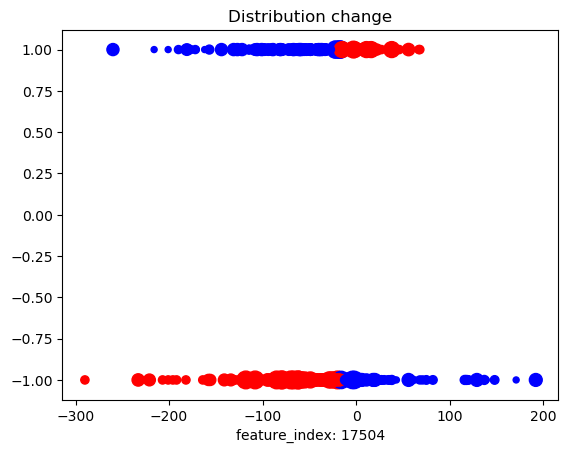

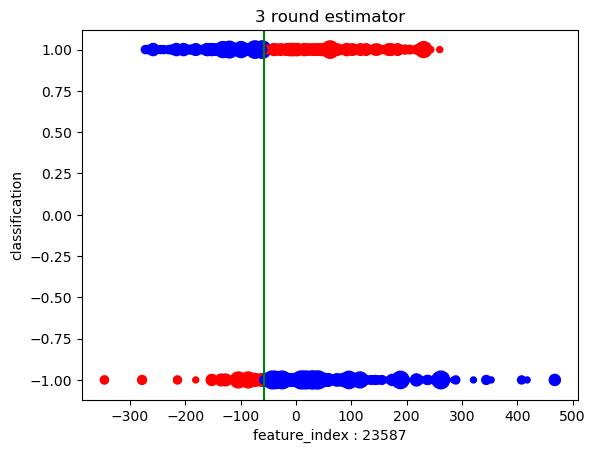

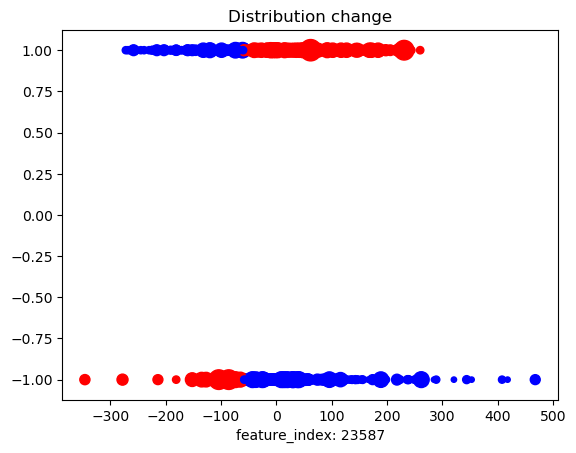

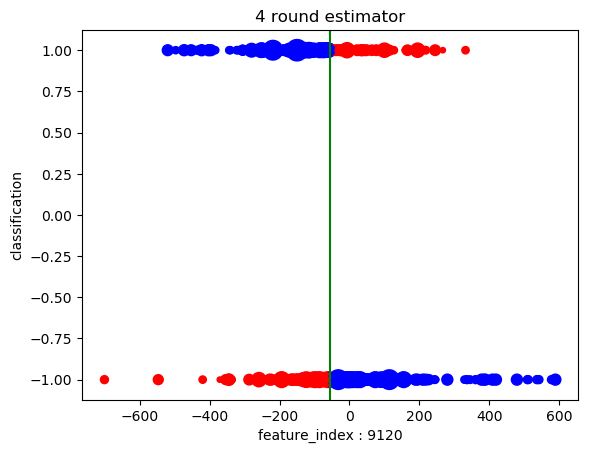

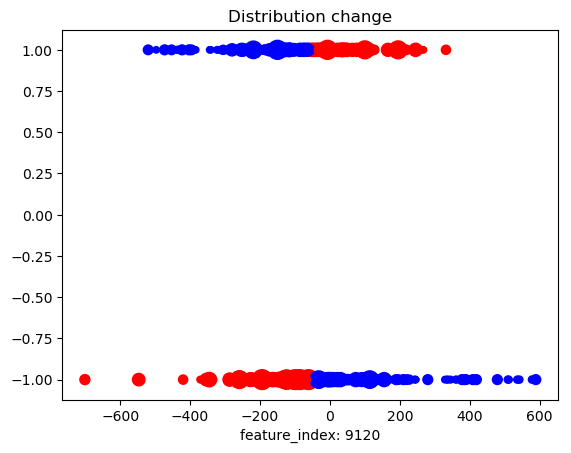

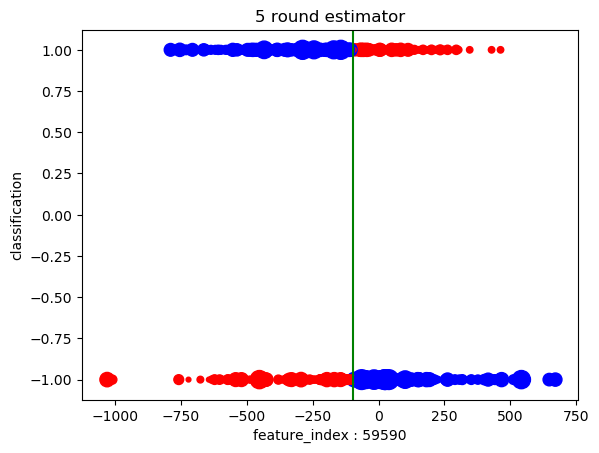

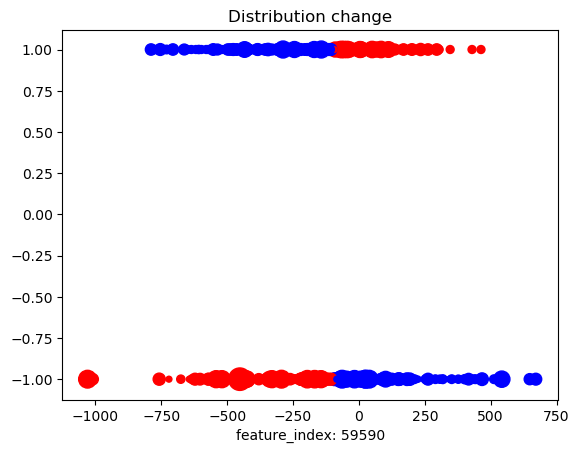

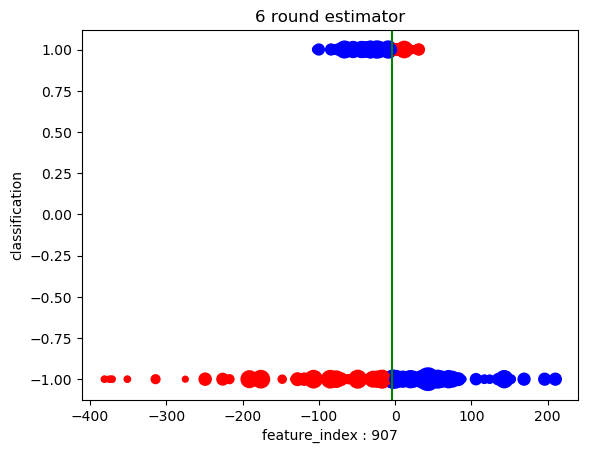

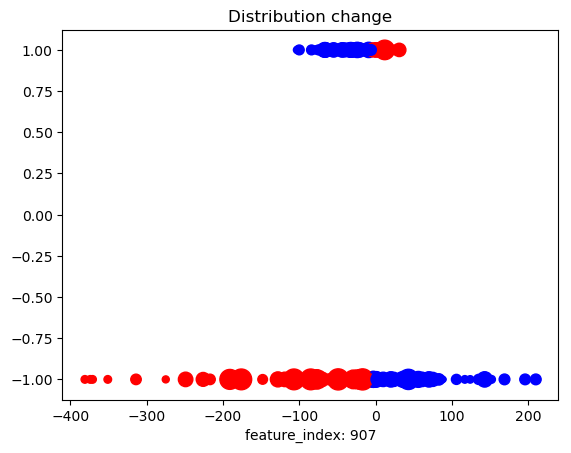

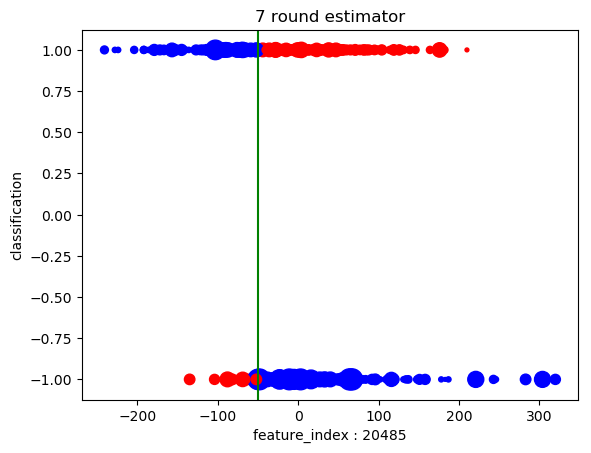

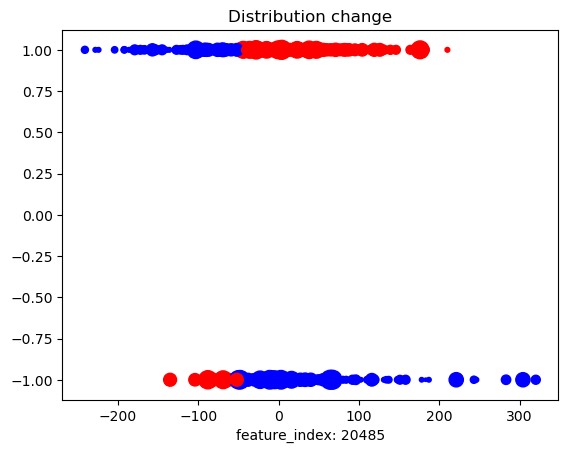

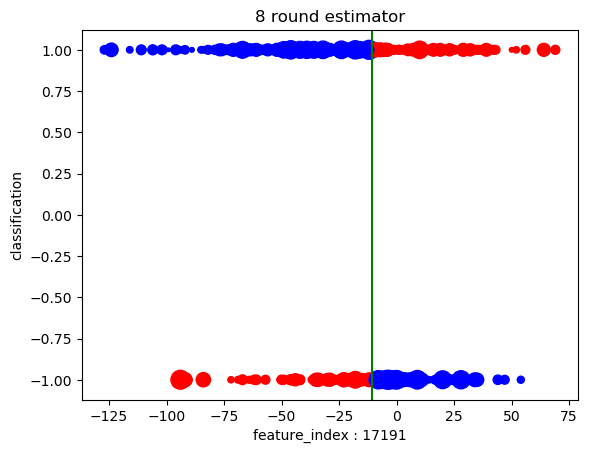

In [71]:
from utils.visualization import decision_stamp_visualization
est = clf.weak_est[0]
decision_stamp_visualization(X, y, est.dist, est, title_text=f"{0} round estimator")
for i, est in enumerate(clf.weak_est[1:]):
    prev_est = clf.weak_est[i]
    fig = plt.figure()
    prediction = prev_est.predict(X)
    color = np.array(["r"]*len(y))
    color[np.where(prediction == y)] = "b"
    plt.scatter(X[:, prev_est.feature_index], y, s=np.sqrt(est.dist)*1500, color=color)
    plt.title("Distribution change")
    plt.xlabel(f"feature_index: {prev_est.feature_index}")
    plt.show()
    
    decision_stamp_visualization(X, y, est.dist, est, title_text=f"{i} round estimator")